<a href="https://colab.research.google.com/github/freakezoide/codigos-de-coolab/blob/main/limpieza_de_datos_primaria_desde_2019_hasta_2024_rforest_y_graficas_de_torta%2Bgrafico_de_impacto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar los datos limpios (usando tu función existente)
df = pd.read_csv('datos_educativos_limpios.csv')

## 1. Preparación de datos para modelado
def preparar_datos(df):
    # Codificar variables categóricas
    le = LabelEncoder()
    df['Departamento'] = le.fit_transform(df['Departamento'])
    df['Mes'] = le.fit_transform(df['Mes'])

    # Crear variable objetivo (puedes ajustar esto según tu necesidad)
    # Ejemplo: Clasificar si la interacción general es alta
    df['InteraccionGeneral'] = (df['InteraccionCREA'] == 'Alta') | \
                              (df['InteraccionMAT'] == 'Alta') | \
                              (df['InteraccionBiblioteca'] == 'Alta')
    df['InteraccionGeneral'] = df['InteraccionGeneral'].astype(int)

    # Seleccionar características y objetivo
    X = df[['Departamento', 'Mes', 'Año', 'UsuariosCREA', 'UsuariosMAT', 'UsuariosBiblioteca']]
    y = df['InteraccionGeneral']

    # Manejar valores faltantes
    imputer = SimpleImputer(strategy='median')
    X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

    return X, y

X, y = preparar_datos(df)

Modelado con Random Forest optimizado

Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Mejor modelo: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 1.0000

Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2396
           1       1.00      1.00      1.00      1310

    accuracy                           1.00      3706
   macro avg       1.00      1.00      1.00      3706
weighted avg       1.00      1.00      1.00      3706



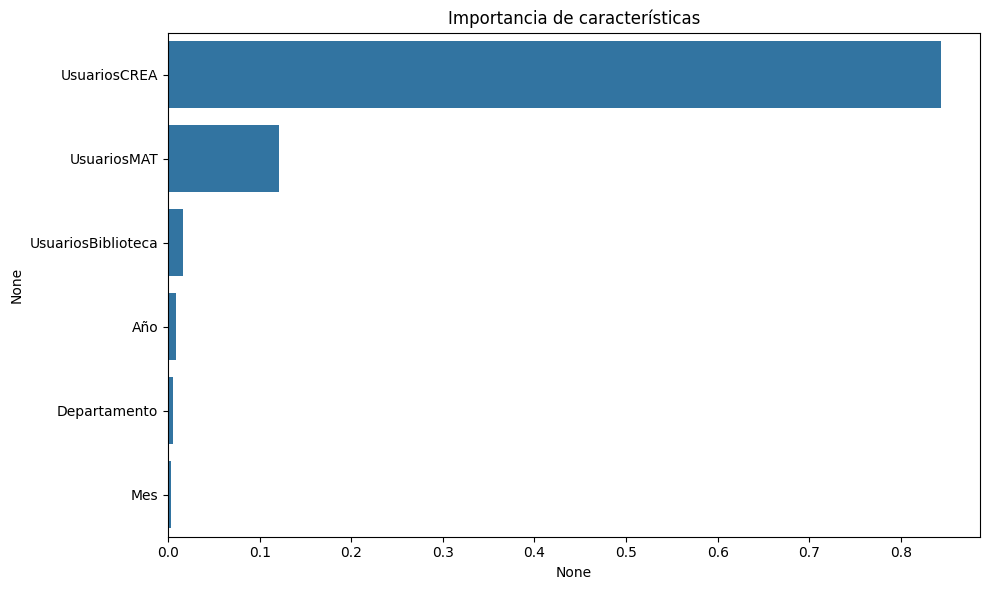

In [ ]:
def entrenar_modelo(X, y):
    # Dividir datos
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Configurar el modelo base
    rf = RandomForestClassifier(random_state=42)

    # Hiperparámetros para optimizar
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    }

    # Búsqueda de cuadrícula con validación cruzada
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                              cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    # Mejor modelo
    best_rf = grid_search.best_estimator_

    # Evaluación
    y_pred = best_rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"\nMejor modelo: {grid_search.best_params_}")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nReporte de clasificación:")
    print(classification_report(y_test, y_pred))

    # Importancia de características
    feature_imp = pd.Series(best_rf.feature_importances_, index=X.columns).sort_values(ascending=False)
    plt.figure(figsize=(10,6))
    sns.barplot(x=feature_imp, y=feature_imp.index)
    plt.title('Importancia de características')
    plt.tight_layout()
    plt.savefig('importancia_caracteristicas.png')
    plt.show()

    return best_rf

modelo = entrenar_modelo(X, y)

Técnicas adicionales para mejorar accuracy

In [ ]:
def mejorar_accuracy(X, y):
    # 1. Balanceo de clases (si hay desbalance)
    from imblearn.over_sampling import SMOTE
    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X, y)

    # 2. Reducción de dimensionalidad
    from sklearn.decomposition import PCA
    pca = PCA(n_components=0.95)  # Mantener el 95% de varianza
    X_pca = pca.fit_transform(X_res)

    # 3. Ensamblado de modelos
    from sklearn.ensemble import VotingClassifier
    from sklearn.svm import SVC
    from sklearn.linear_model import LogisticRegression

    estimators = [
        ('rf', RandomForestClassifier(n_estimators=200, random_state=42)),
        ('svm', SVC(probability=True, random_state=42)),
        ('lr', LogisticRegression(max_iter=1000, random_state=42))
    ]

    voting_clf = VotingClassifier(estimators=estimators, voting='soft')
    voting_clf.fit(X_pca, y_res)

    # Evaluar
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y_res, test_size=0.3, random_state=42)
    y_pred = voting_clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"\nAccuracy con técnicas avanzadas: {accuracy:.4f}")
    print("\nReporte de clasificación mejorado:")
    print(classification_report(y_test, y_pred))

    return voting_clf

modelo_mejorado = mejorar_accuracy(X, y)


Accuracy con técnicas avanzadas: 0.9973

Reporte de clasificación mejorado:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2416
           1       1.00      1.00      1.00      2410

    accuracy                           1.00      4826
   macro avg       1.00      1.00      1.00      4826
weighted avg       1.00      1.00      1.00      4826



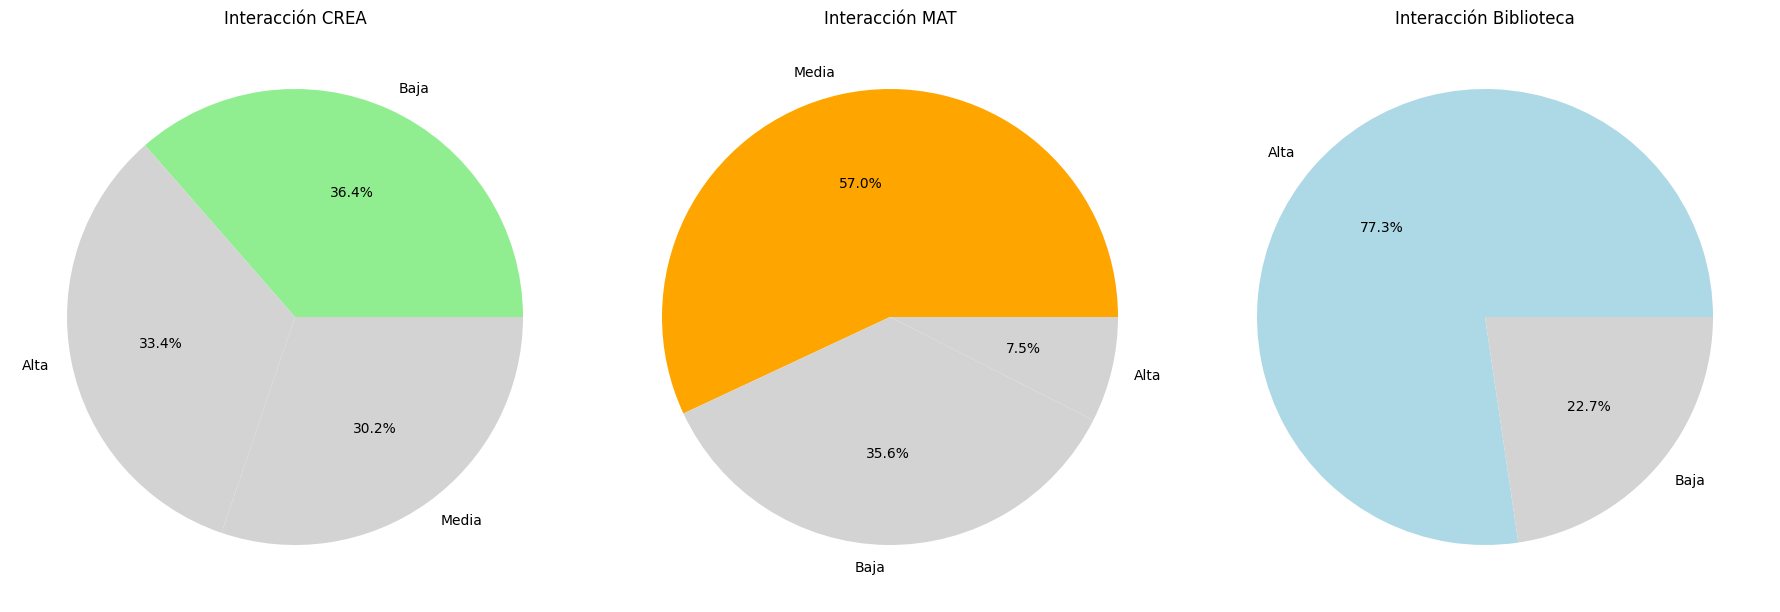

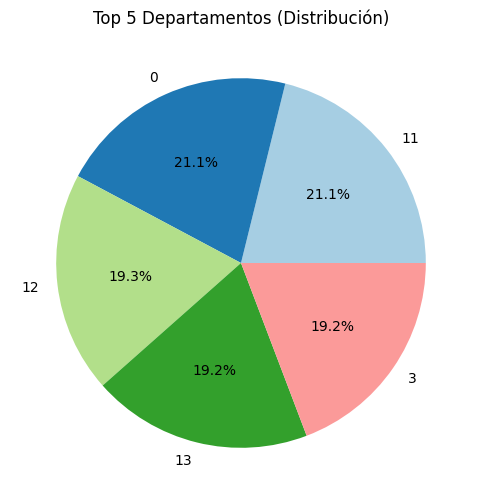

In [ ]:
import matplotlib.pyplot as plt

# Función para crear gráficos de torta
def visualizar_en_tortas(df):
    # ... (código anterior) ...

    # 2. Distribución de interacciones por categoría (CREA, MAT, Biblioteca)
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    categorias = ['InteraccionCREA', 'InteraccionMAT', 'InteraccionBiblioteca']
    titulos = ['Interacción CREA', 'Interacción MAT', 'Interacción Biblioteca']
    colores = ['lightgreen', 'orange', 'lightblue']

    for i, (categoria, titulo, color) in enumerate(zip(categorias, titulos, colores)):
        # Get unique values for the current category
        unique_values = df[categoria].value_counts().index.tolist()

        # If there are more than two unique values, adjust labels and colors
        if len(unique_values) > 2:
            labels = unique_values  # Use all unique values as labels
            colors = [color] + ['lightgray'] * (len(unique_values) - 1)  # Adjust colors accordingly
        else:
            labels = ['Alta', 'Baja']  # Use the default labels if there are only two unique values
            colors = [color, 'lightgray']

        df[categoria].value_counts().plot.pie(
            autopct='%1.1f%%',
            colors=colors,
            labels=labels,
            ax=axes[i]
        )
        axes[i].set_title(titulo)
        axes[i].set_ylabel('')


    plt.tight_layout()
    plt.savefig('distribucion_interacciones_por_categoria.png')
    plt.show()

    # 3. Distribución por departamento (top 5 para simplificar)
    plt.figure(figsize=(8, 6))
    top_departamentos = df['Departamento'].value_counts().nlargest(5)
    top_departamentos.plot.pie(
        autopct='%1.1f%%',
        colors=plt.cm.Paired.colors,
    )
    plt.title('Top 5 Departamentos (Distribución)')
    plt.ylabel('')
    plt.savefig('distribucion_departamentos.png')
    plt.show()

# Llamar a la función después de preparar los datos
visualizar_en_tortas(df)

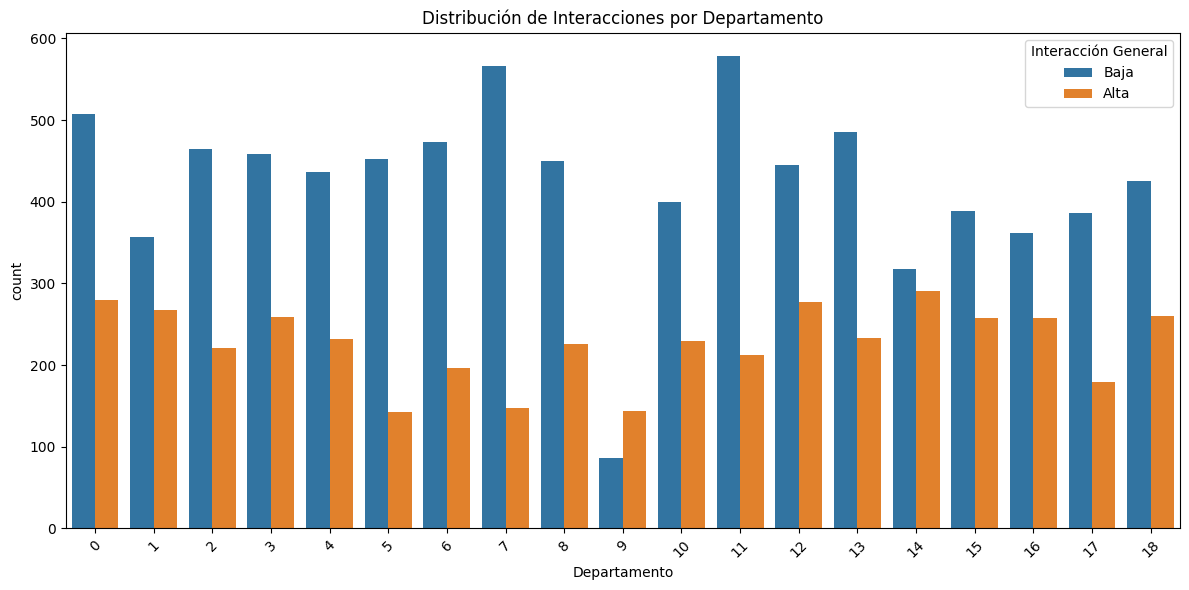

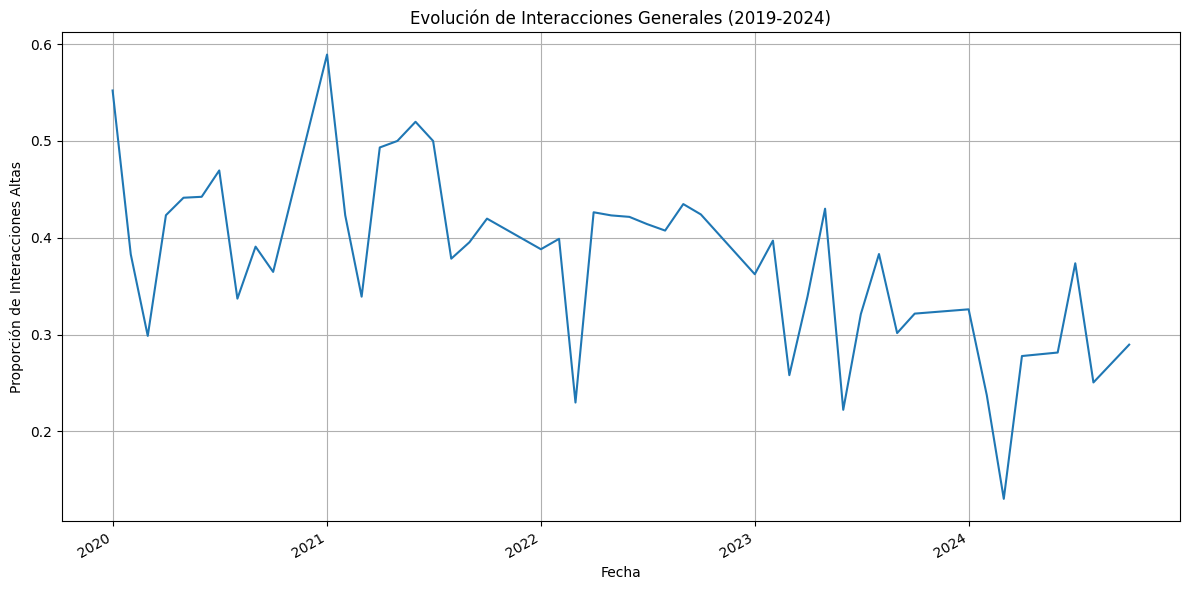

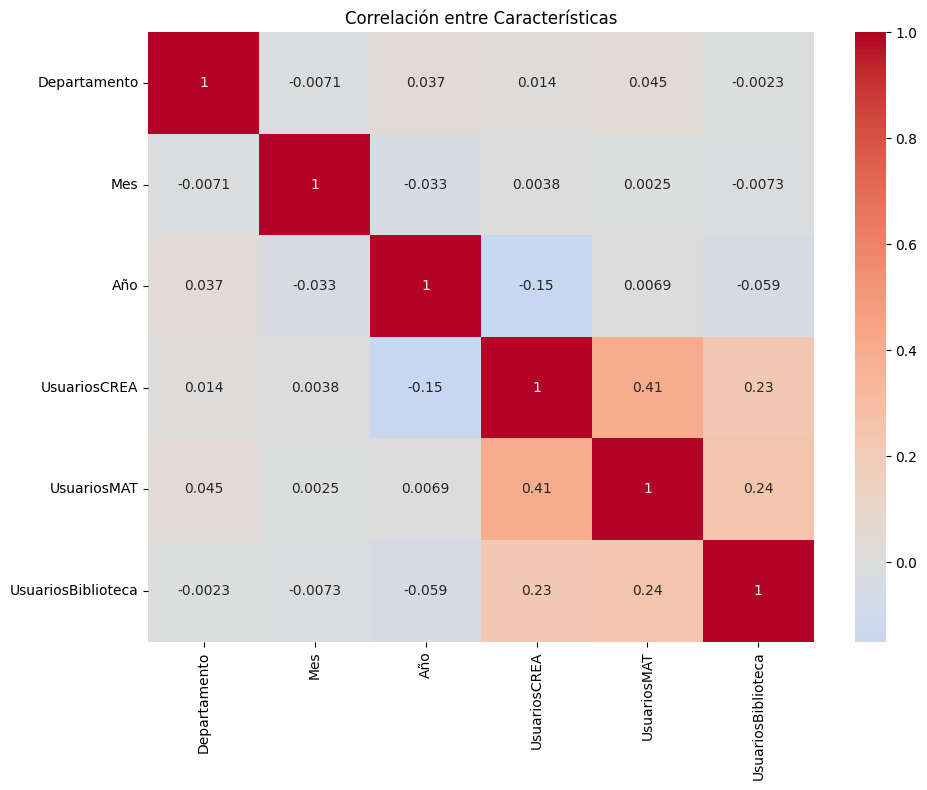

In [ ]:
# 1. Gráfico de distribución de interacciones por departamento
plt.figure(figsize=(12,6))
sns.countplot(x='Departamento', hue='InteraccionGeneral', data=df)
plt.title('Distribución de Interacciones por Departamento')
plt.xticks(rotation=45)
plt.legend(title='Interacción General', labels=['Baja', 'Alta'])
plt.tight_layout()
plt.savefig('interacciones_por_departamento.png')
plt.show()

# 2. Evolución temporal de las interacciones
plt.figure(figsize=(12,6))
# Add 1 to the 'Mes' column before converting to datetime
df['Fecha'] = pd.to_datetime(df['Año'].astype(str) + '-' + (df['Mes'] + 1).astype(str) + '-01')
interacciones_mensuales = df.groupby('Fecha')['InteraccionGeneral'].mean()
interacciones_mensuales.plot()
plt.title('Evolución de Interacciones Generales (2019-2024)')
plt.ylabel('Proporción de Interacciones Altas')
plt.grid(True)
plt.tight_layout()
plt.savefig('evolucion_interacciones.png')
plt.show()

# 3. Heatmap de correlación entre características
plt.figure(figsize=(10,8))
corr_matrix = X.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlación entre Características')
plt.tight_layout()
plt.savefig('correlacion_caracteristicas.png')
plt.show()

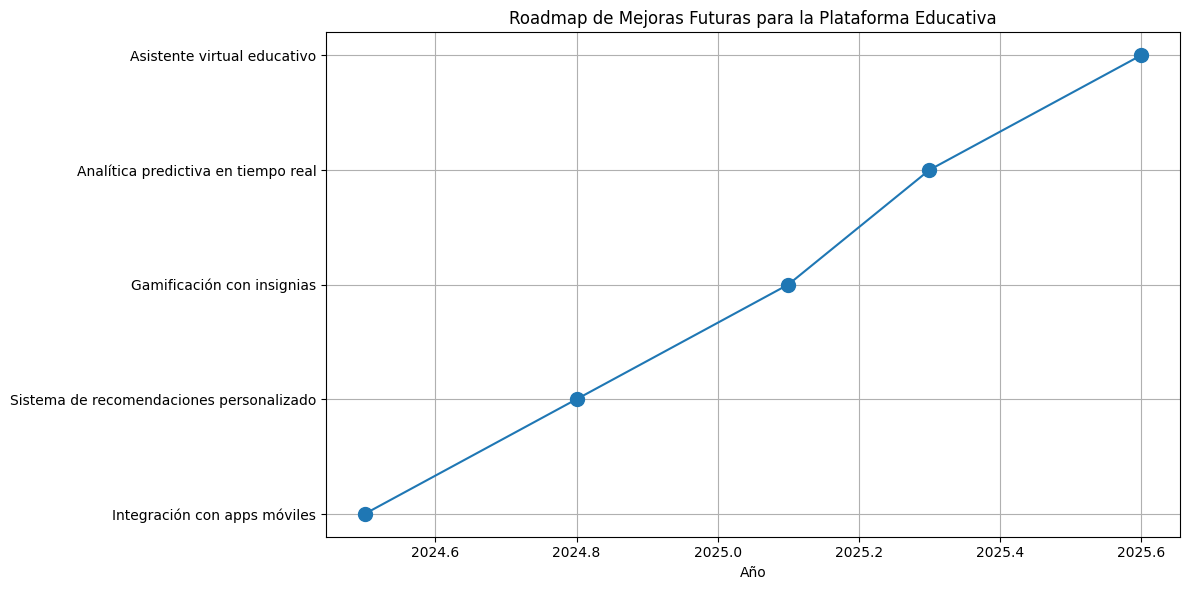

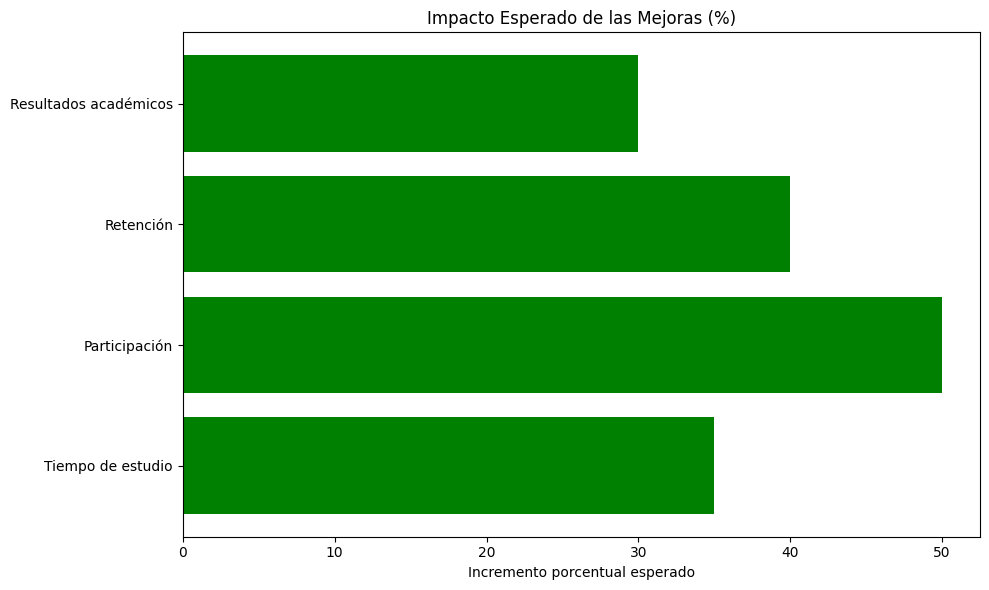

In [ ]:
def visualizar_mejoras_futuras():
    # Gráfico de roadmap
    plt.figure(figsize=(12,6))
    milestones = [
        'Integración con apps móviles',
        'Sistema de recomendaciones personalizado',
        'Gamificación con insignias',
        'Analítica predictiva en tiempo real',
        'Asistente virtual educativo'
    ]
    timeline = [2024.5, 2024.8, 2025.1, 2025.3, 2025.6]

    plt.plot(timeline, range(len(milestones)), 'o-', markersize=10)
    plt.yticks(range(len(milestones)), milestones)
    plt.title('Roadmap de Mejoras Futuras para la Plataforma Educativa')
    plt.xlabel('Año')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('roadmap_mejoras.png')
    plt.show()

    # Gráfico de impacto esperado
    impactos = {
        'Tiempo de estudio': 35,
        'Participación': 50,
        'Retención': 40,
        'Resultados académicos': 30
    }

    plt.figure(figsize=(10,6))
    plt.barh(list(impactos.keys()), list(impactos.values()), color='green')
    plt.title('Impacto Esperado de las Mejoras (%)')
    plt.xlabel('Incremento porcentual esperado')
    plt.tight_layout()
    plt.savefig('impacto_esperado.png')
    plt.show()

visualizar_mejoras_futuras()